<a href="https://colab.research.google.com/github/emirhangull/StrokePrediction/blob/edamete/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Emirhan Gül
Efe Arda Uzunova
Mete Oktar

# Inme (Stroke) Veri Analizi (EDA)
Bu bölümde veri setinin genel yapısını inceleyip, eksik değerler, sınıf dağılımı, sayısal ve kategorik değişkenlerin dağılımları ile temel ilişkileri görselleştireceğiz.

Hedefler:
- Veri setini yükleme ve genel bakış (boyut, sütunlar, tipler)
- Eksik değer analizi
- Hedef değişken dağılımı (sınıf dengesizliği)
- Sayısal değişkenler: dağılım ve aykırı değerler
- Kategorik değişkenler: sınıf kırılımında dağılımlar
- Korelasyon ısı haritası (sayısal özellikler + hedef)

Not: Bu aşamada yalnızca keşifsel analiz yapılır; dönüşüm/ölçekleme gibi adımlar bir sonraki bölümde ele alınacaktır.

In [2]:
# Gerekli Kütüphaneler (EDA)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Görsel ve çıktı ayarları
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

sns.set(style="whitegrid", palette="Set2",
        rc={"axes.spines.right": False, "axes.spines.top": False})

%matplotlib inline

In [3]:
# 1) Veriyi Yükleme
import os

df = pd.read_csv('data.csv')

print(f"Satır: {df.shape[0]:,} | Sütun: {df.shape[1]}")
display(df.head())

Satır: 5,110 | Sütun: 12


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [4]:
# 2) Genel Bakış: sütunlar, tipler, özet istatistikler
print('\nSütunlar:')

for i in list(df.columns):
    print(i)

print('\nVeri Tipleri:')
print(df.dtypes)

print('\nSayısal Özet :')
display(df.describe())


Sütunlar:
id
gender
age
hypertension
heart_disease
ever_married
work_type
Residence_type
avg_glucose_level
bmi
smoking_status
stroke

Veri Tipleri:
id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Sayısal Özet :


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,"5,110.00","5,110.00","5,110.00","5,110.00","5,110.00","4,909.00","5,110.00"
mean,"36,517.83",43.23,0.10,0.05,106.15,28.89,0.05
std,"21,161.72",22.61,0.30,0.23,45.28,7.85,0.22
min,67.00,0.08,0.00,0.00,55.12,10.30,0.00
25%,"17,741.25",25.00,0.00,0.00,77.25,23.50,0.00
50%,"36,932.00",45.00,0.00,0.00,91.88,28.10,0.00
75%,"54,682.00",61.00,0.00,0.00,114.09,33.10,0.00
max,"72,940.00",82.00,1.00,1.00,271.74,97.60,1.00


In [5]:
print("N/A or Unknown values count by column")
df['smoking_status'] = df['smoking_status'].replace('Unknown', np.nan)
df.isna().sum()


N/A or Unknown values count by column


id                      0
gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   201
smoking_status       1544
stroke                  0
dtype: int64

Görüldüğü gibi sadece bmi (201) ve smoking status (1544) sütunlarında N/A ve unknown değerleri var.

In [6]:
print(
    f"BMI NaN sayısı: {df['bmi'].isnull().sum()} | "
    f"BMI NaN oranı: {df['bmi'].isnull().mean():.2%}\n"
    f"Smoking Unknown sayısı: {df['smoking_status'].isnull().sum()} | "
    f"Smoking Unknown oranı: {df['smoking_status'].isnull().mean():.2%}\n"
)
display(df['bmi'].describe())
display(df['smoking_status'].value_counts())




BMI NaN sayısı: 201 | BMI NaN oranı: 3.93%
Smoking Unknown sayısı: 1544 | Smoking Unknown oranı: 30.22%



count   4,909.00
mean       28.89
std         7.85
min        10.30
25%        23.50
50%        28.10
75%        33.10
max        97.60
Name: bmi, dtype: float64

smoking_status
never smoked       1892
formerly smoked     885
smokes              789
Name: count, dtype: int64

Eksik değer sayıları ve yüzdeleri:


,missing,percent
smoking_status,1544,30.22
bmi,201,3.93


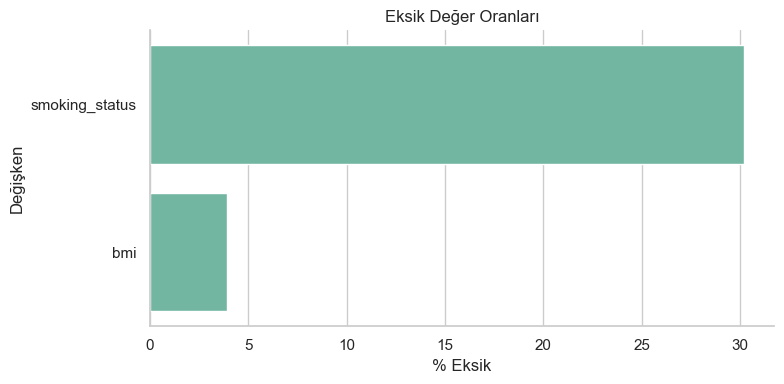

In [7]:
# 3) Eksik Değer Analizi


missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df)).sort_values(ascending=False)
missing_df = pd.DataFrame({
    'missing': missing_counts,
    'percent': (missing_pct * 100).round(2)
})

print('Eksik değer sayıları ve yüzdeleri:')
display(missing_df[missing_df['missing'] > 0])

plt.figure(figsize=(8, 4))
sns.barplot(x=missing_df[missing_df['missing']>0]['percent'],
            y=missing_df[missing_df['missing']>0].index,
            orient='h', color='#66c2a5')
plt.xlabel('% Eksik')
plt.ylabel('Değişken')
plt.title('Eksik Değer Oranları')
plt.tight_layout()
plt.show()

BMI'daki NaN değerleri medyan ile doldurulacak, Smoking_Status'teki Unknown değerleri ise ayrı bir kategori olarak ele alınacaktır.

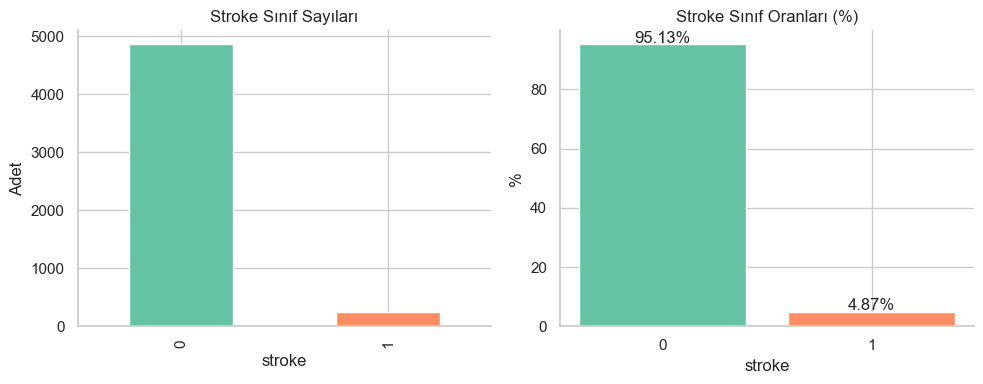

Sınıf oranları (%):
stroke
0   95.13
1    4.87
Name: count, dtype: float64


In [8]:
# 4)veride stroke dagilimi nasıl
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
vc = df['stroke'].value_counts().sort_index()
vc.plot(kind='bar', ax=ax[0], color=['#66c2a5', '#fc8d62'])
ax[0].set_title('Stroke Sınıf Sayıları')
ax[0].set_xlabel('stroke')
ax[0].set_ylabel('Adet')

ratio = (vc / vc.sum() * 100).round(2)
ax[1].bar(ratio.index.astype(str), ratio.values, color=['#66c2a5', '#fc8d62'])
ax[1].set_title('Stroke Sınıf Oranları (%)')
ax[1].set_xlabel('stroke')
ax[1].set_ylabel('%')
for i, v in enumerate(ratio.values):
    ax[1].text(i, v + 0.5, f"{v}%", ha='center')
plt.tight_layout()
plt.show()

print('Sınıf oranları (%):')
print(ratio)

İnme tahmininde bulunduğumuz için true positive'leri kaçırmamalıyız. Yani bütün true positiveleri yakalamamız ve false negative sayısını olabildiğince minimize etmemiz gerekiyor. Özetle Recall değerimizin 1'e olabildiğince yakın olması gerek.

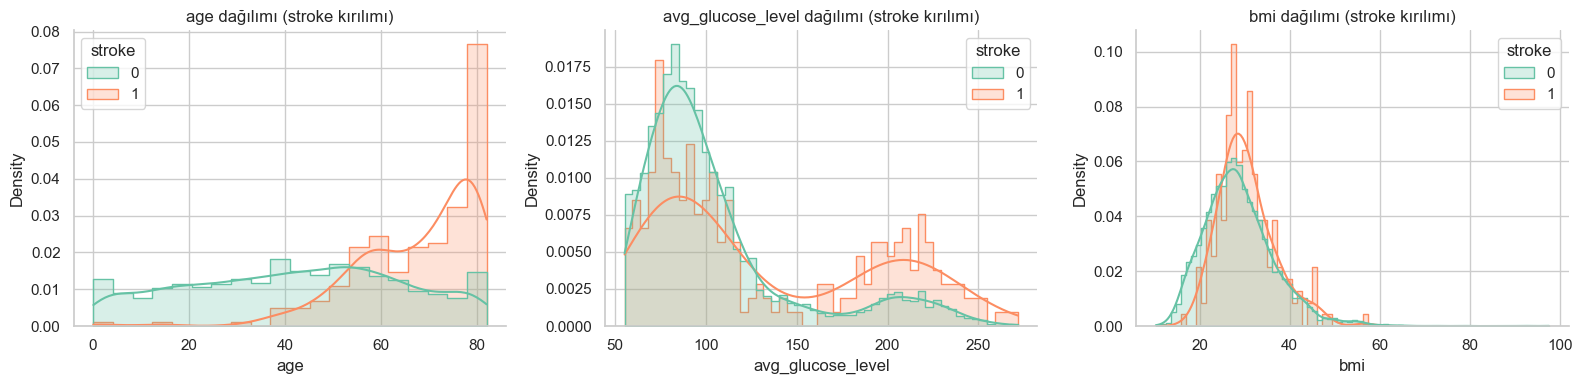

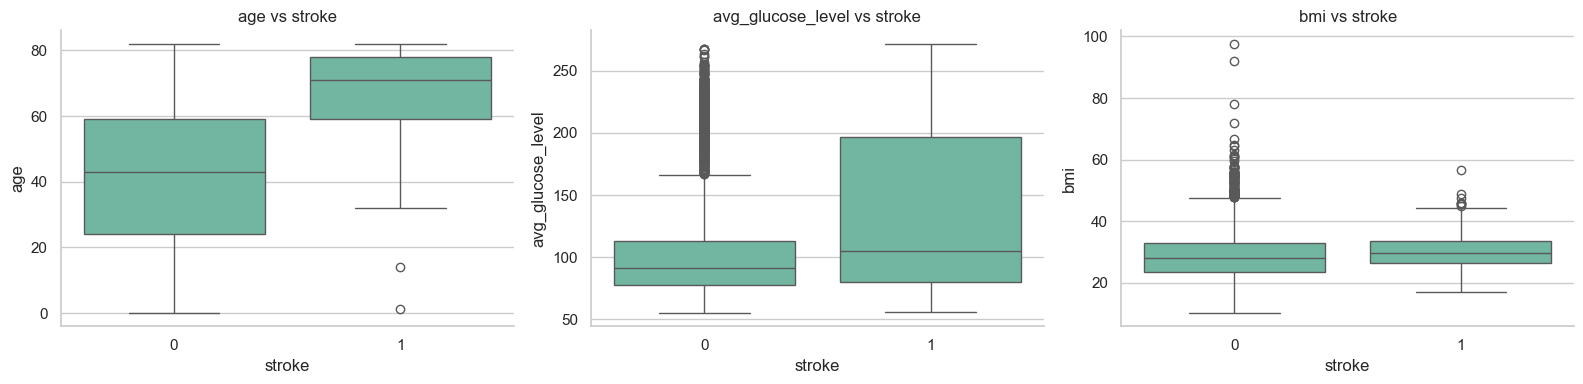

In [9]:

num_cols = ['age', 'avg_glucose_level', 'bmi']

# Histogram
fig, axes = plt.subplots(1, len(num_cols), figsize=(16, 4))
for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, hue='stroke', element='step', stat='density',
                 common_norm=False, kde=True, ax=axes[i])
    axes[i].set_title(f'{col} dağılımı (stroke kırılımı)')
plt.tight_layout()
plt.show()

# Boxplot
fig, axes = plt.subplots(1, len(num_cols), figsize=(16, 4))
for i, col in enumerate(num_cols):
    sns.boxplot(data=df, x='stroke', y=col, ax=axes[i])
    axes[i].set_title(f'{col} vs stroke')
plt.tight_layout()
plt.show()

Histogram dağılımlarından yaş faktörünün inme geçirme ile yakından ilişkili olduğunu görebiliriz. Yaş arttıkça inme oranı artıyor.

Stroke ve avg glucose level grafiğinden de age kadar olmasa da şeker seviyesinin de inme geçirip geçirmemeyle ilişkili olduğunu görebiliyoruz.
Burada dikkat etmemiz gereken iki durum var

1- İnme değerinin 80 glucose_level değerlerinde peak etmesinin sebebi tüm insanlarda 70-126 mg/dL arasının normal değer kabul edilmesi ve insanların çoğunun bu aralıkta bulunması. Yani 80 civarında inme geçiren hastaların avg glucose degeriyle bir alakası yok denebilir.

2- Fakat inme değerinin 200 mg/dL civarında yeniden artmasının sebebi şekeri yüksek insanların inme geçirmeye daha eğilimli olması olarak yorumlanabilir.

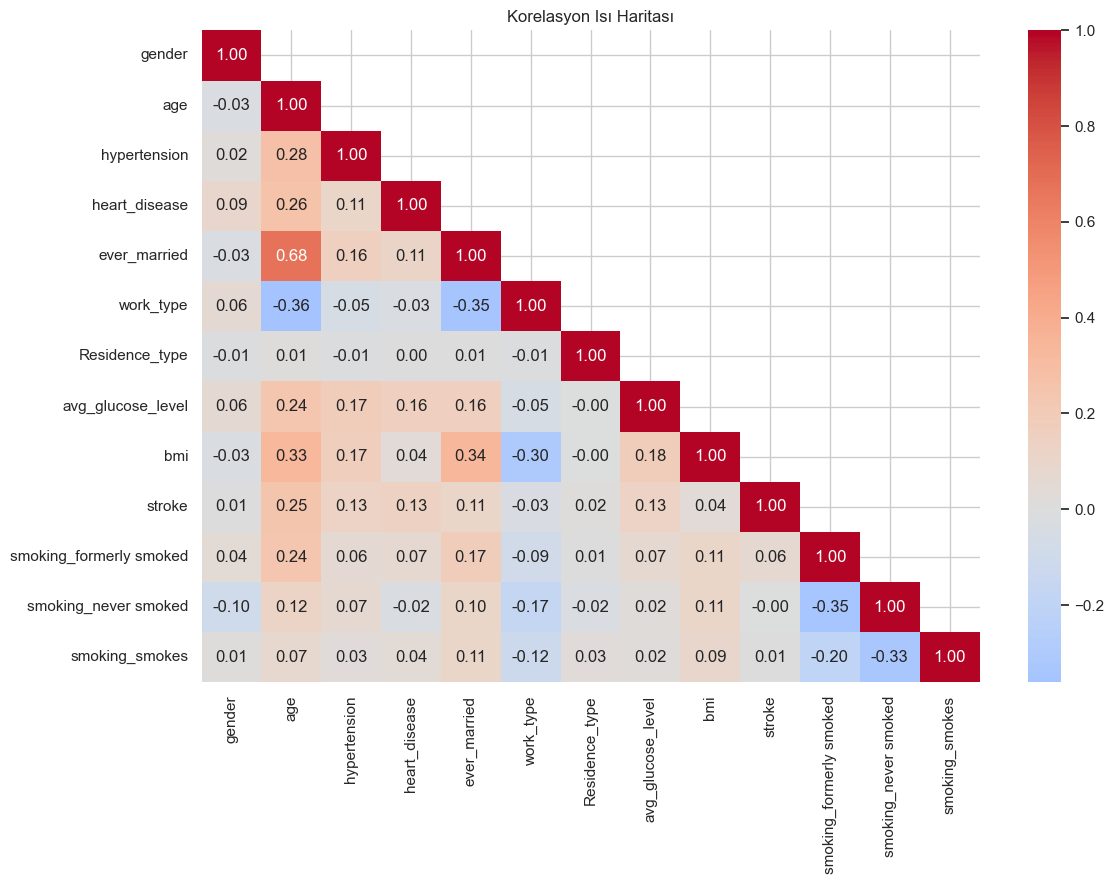


Stroke ile Korelasyonlar:
stroke                     1.00
age                        0.25
heart_disease              0.13
avg_glucose_level          0.13
hypertension               0.13
ever_married               0.11
smoking_formerly smoked    0.06
bmi                        0.04
Residence_type             0.02
smoking_smokes             0.01
gender                     0.01
smoking_never smoked      -0.00
work_type                 -0.03
Name: stroke, dtype: float64


In [10]:
# 6) Korelasyon Isı Haritası

# ana df etkilenmemesi için ayrı bir df
df_corr = df.copy().drop(columns=['id', 'age_group'], errors='ignore')

# smoking status'u one-hot-encode et
smoke_dummies = pd.get_dummies(df_corr['smoking_status'], prefix='smoking')
df_corr = pd.concat([df_corr.drop(columns=['smoking_status']), smoke_dummies], axis=1)

# kategorikleri label ile encoding
cat_cols = df_corr.select_dtypes(exclude=['number']).columns
le = LabelEncoder()
for col in cat_cols:
    df_corr[col] = le.fit_transform(df_corr[col].astype(str))

corr_all = df_corr.corr(numeric_only=True)

mask = np.triu(np.ones_like(corr_all, dtype=bool), k=1)

#heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(corr_all, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Korelasyon Isı Haritası")
plt.tight_layout()
plt.show()

print("\nStroke ile Korelasyonlar:")
print(corr_all['stroke'].sort_values(ascending=False))

Bu korelasyon haritasından da görülebileceği gibi stroke ile korelasyonda yaş en büyük faktör iken, avg_glucose_level, heart_disease ve hypertension 2. sırada geliyor.

Öznitelikler arasındaki korelasyonları görebilmek de bu grafikten mümkün.
Yaş ve ever_married gibi

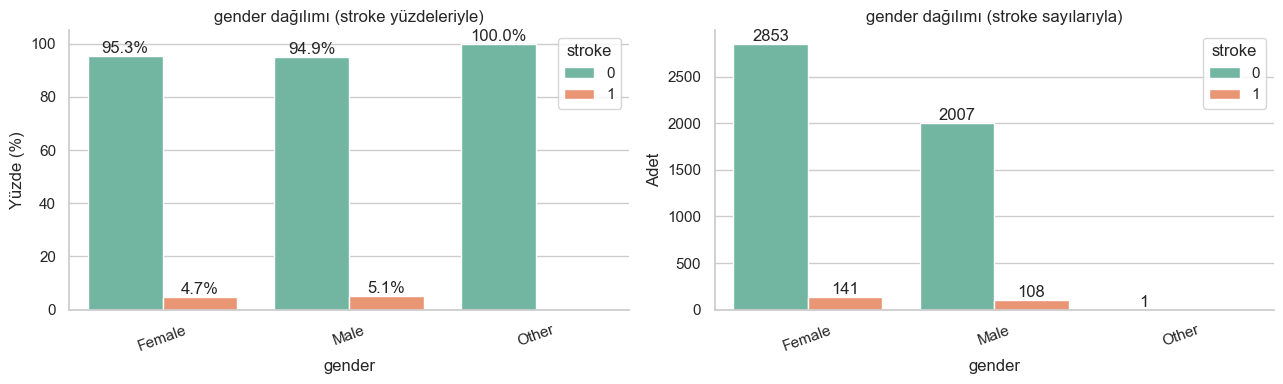

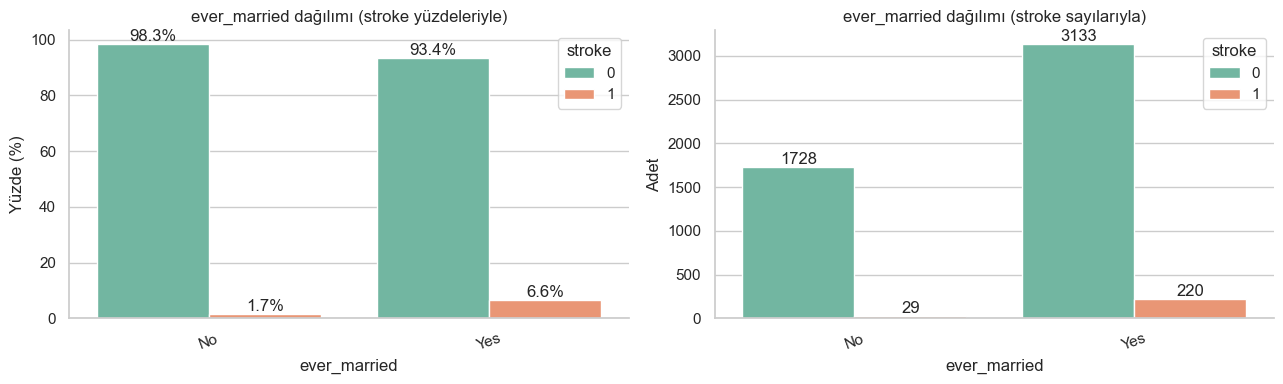

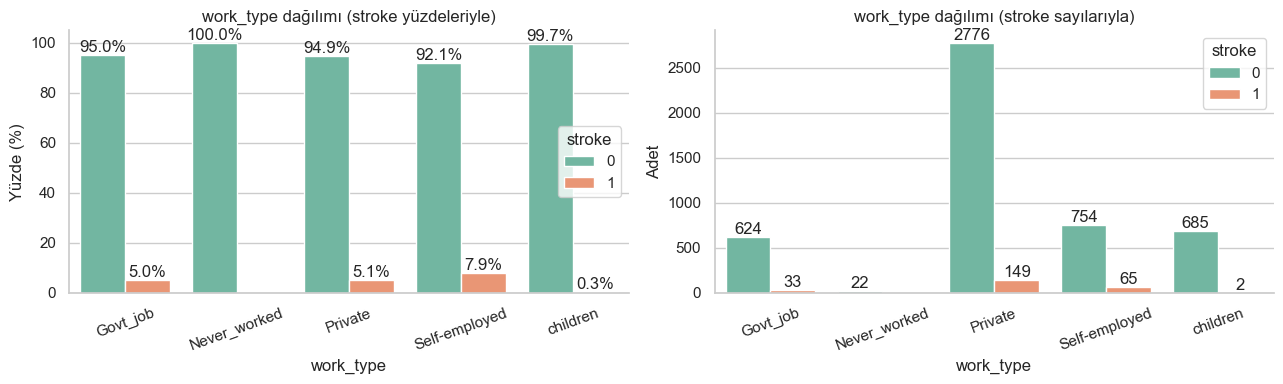

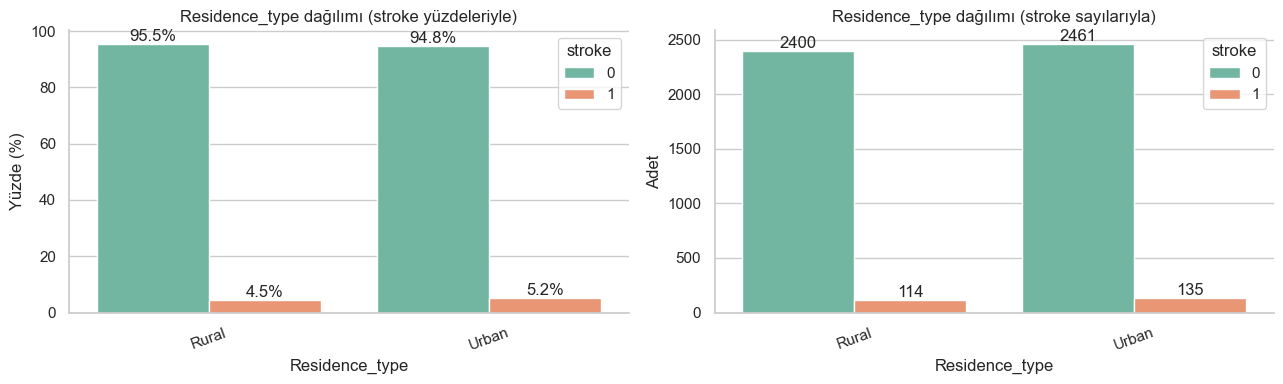

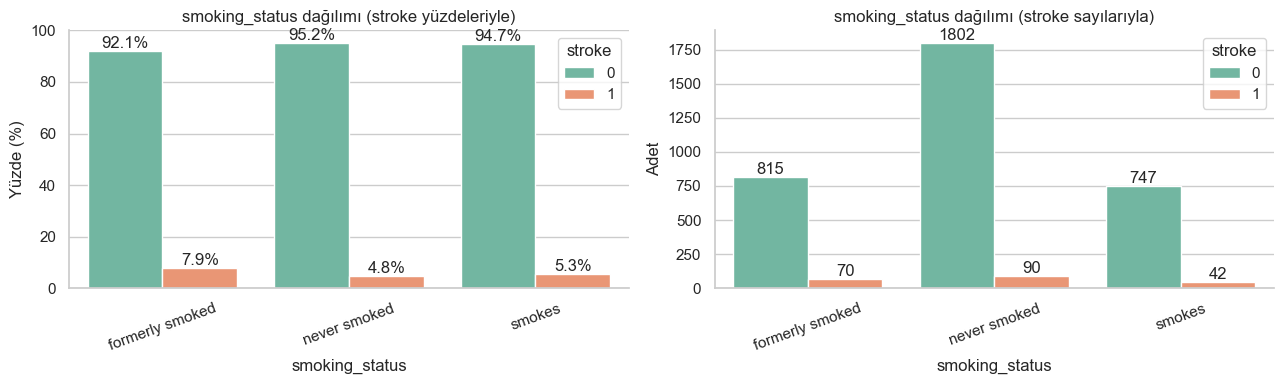

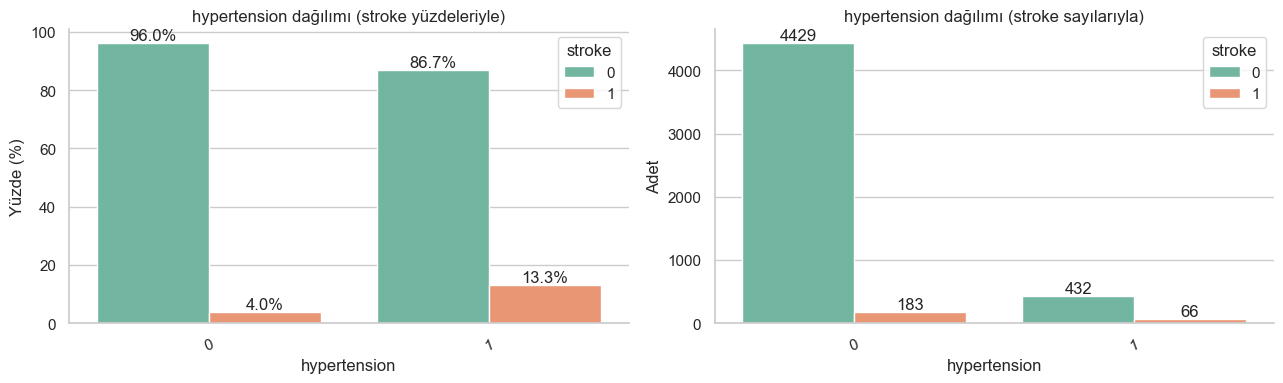

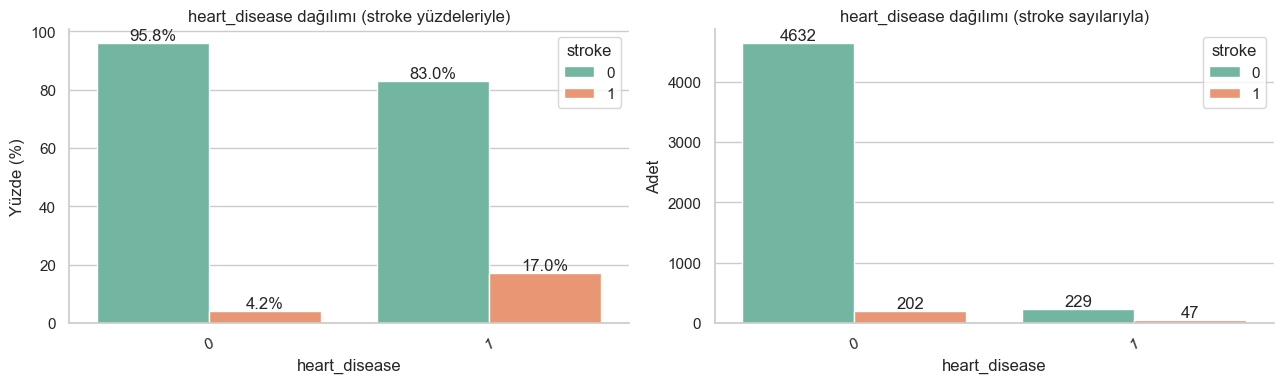

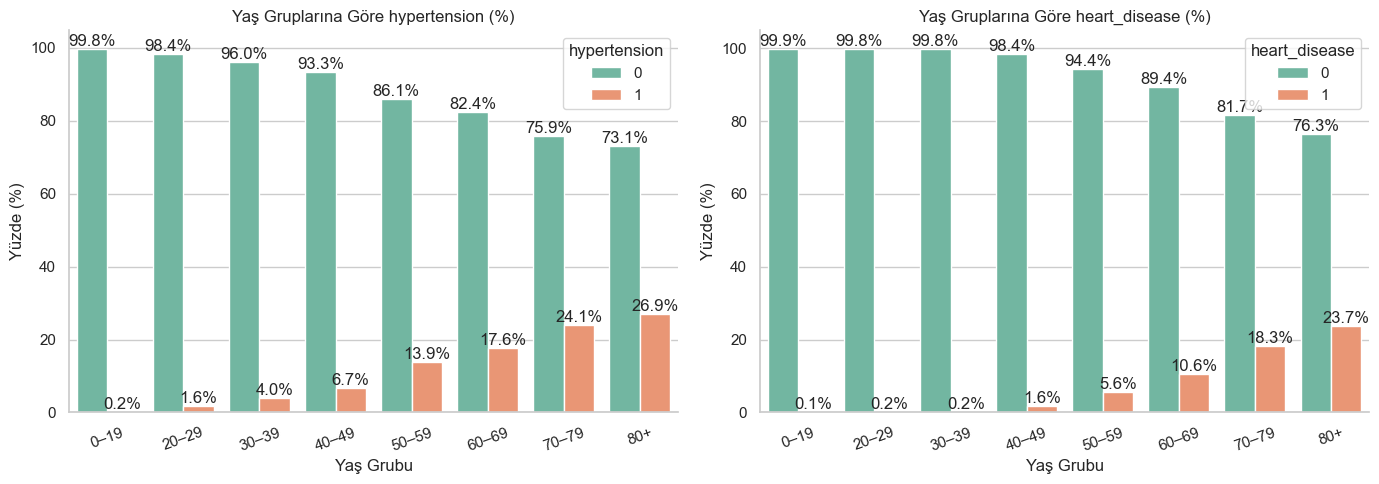

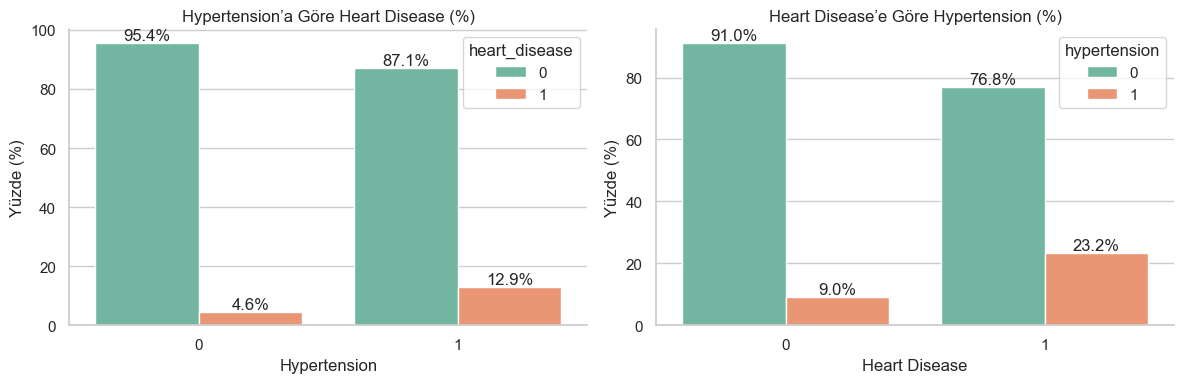

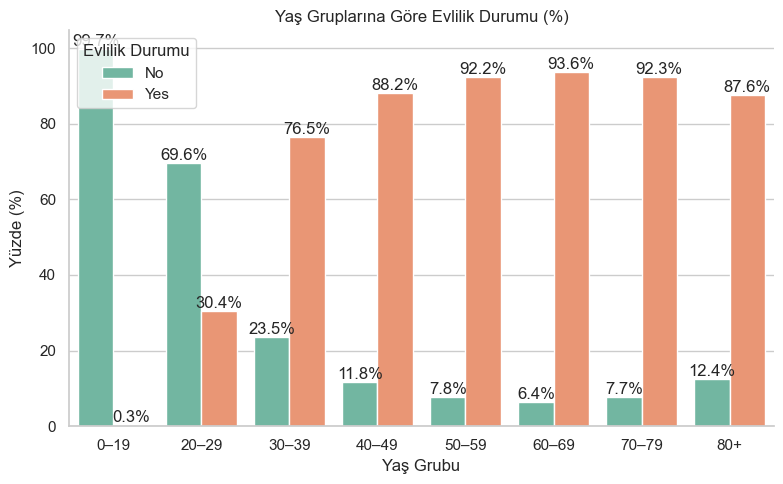

In [11]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# satir bazinda yuzde hesapliyor
def pct_table(df, x, hue):
    return (
        df.groupby([x, hue], observed=False)
          .size()
          .groupby(level=0, observed=False)
          .transform(lambda s: 100 * s / s.sum())
          .reset_index(name='percent')
    )

cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type',
            'smoking_status', 'hypertension', 'heart_disease']

for col in cat_cols:
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))

    # percentile graph
    data_pct = pct_table(df, col, 'stroke')
    ax = sns.barplot(data=data_pct, x=col, y='percent', hue='stroke', ax=axes[0])
    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f%%')
    axes[0].set_title(f'{col} dağılımı (stroke yüzdeleriyle)')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Yüzde (%)')
    axes[0].tick_params(axis='x', rotation=20)

    # sayisal graph
    data_count = df.groupby([col, 'stroke'], observed=False).size().reset_index(name='count')
    ax2 = sns.barplot(data=data_count, x=col, y='count', hue='stroke', ax=axes[1])
    for c in ax2.containers:
        ax2.bar_label(c, fmt='%d')
    axes[1].set_title(f'{col} dağılımı (stroke sayılarıyla)')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Adet')
    axes[1].tick_params(axis='x', rotation=20)

    plt.tight_layout()
    plt.show()

#age binleri
bins   = [0, 20, 30, 40, 50, 60, 70, 80, 120]
labels = ['0–19', '20–29', '30–39', '40–49', '50–59', '60–69', '70–79', '80+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
targets = ['hypertension', 'heart_disease']
#yas gruplarina gore hypertension ve heartdisease
for i, h in enumerate(targets):
    d = pct_table(df, 'age_group', h)
    ax = axes[i]
    sns.barplot(data=d, x='age_group', y='percent', hue=h, ax=ax)
    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f%%')
    ax.set_title(f'Yaş Gruplarına Göre {h} (%)')
    ax.set_xlabel('Yaş Grubu')
    ax.set_ylabel('Yüzde (%)')
    ax.legend(title=h)
    ax.tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# hypertension'u olan insanlar heart_disease'e daha mı yatkın
data_ht_hd = pct_table(df, 'hypertension', 'heart_disease')
sns.barplot(data=data_ht_hd, x='hypertension', y='percent',
            hue='heart_disease', ax=axes[0])
for c in axes[0].containers:
    axes[0].bar_label(c, fmt='%.1f%%')
axes[0].set_title('Hypertension’a Göre Heart Disease (%)')
axes[0].set_xlabel('Hypertension'); axes[0].set_ylabel('Yüzde (%)')

# heart_disease'i bulunan insanlar hypertension'a daha mı yatkın
data_hd_ht = pct_table(df, 'heart_disease', 'hypertension')
sns.barplot(data=data_hd_ht, x='heart_disease', y='percent',
            hue='hypertension', ax=axes[1])
for c in axes[1].containers:
    axes[1].bar_label(c, fmt='%.1f%%')
axes[1].set_title('Heart Disease’e Göre Hypertension (%)')
axes[1].set_xlabel('Heart Disease'); axes[1].set_ylabel('Yüzde (%)')

plt.tight_layout()
plt.show()

#yas gruplarina gore ever_married olup olmadigi
data_age_married = pct_table(df, 'age_group', 'ever_married')
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=data_age_married, x='age_group', y='percent', hue='ever_married')
for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%')
plt.title('Yaş Gruplarına Göre Evlilik Durumu (%)')
plt.xlabel('Yaş Grubu'); plt.ylabel('Yüzde (%)')
plt.legend(title='Evlilik Durumu')
plt.tight_layout(); plt.show()


NameError: name 'dfcleaned' is not defined

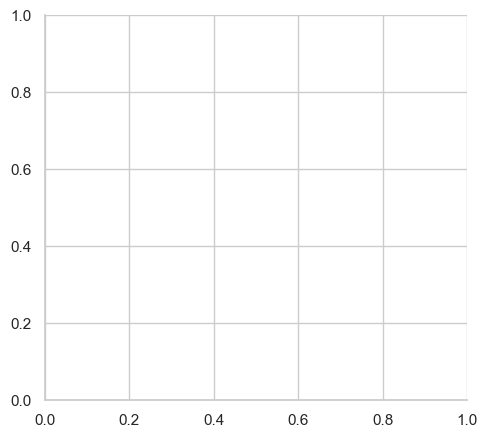

In [12]:
# Age vs Stroke
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
dfcleaned.groupby('age')['stroke'].mean().plot(marker='o')
plt.xlabel('Age')
plt.ylabel('Stroke Rate')
plt.title('Yaş Gruplarına Göre İnme Oranı')

plt.subplot(1, 2, 2)
sns.boxplot(data=dfcleaned, x='stroke', y='age')
plt.title('Age vs Stroke')
plt.tight_layout()
plt.show()

Yukarıdaki kategorik veri grafiklerinden de ilk bakışta heart_disease , hypertension , ever_married ve yaş verilerinin inme geçirip geçirmemeyle diğer değerlere göre daha ilişkili olduğunu görebiliriz. Fakat bu verilerin birbirlerinden bağımsız olmadığını, hem birbirleriyle hem de yaş ile ilişkili olduğunu göz önünde bulundurmalıyız. Örneğin:

1- yaş arttıkça ever_married değerinin 1 olma eğilimi artıyor

2- yaş arttıkça hypertension ve heart_disease olma eğilimi artıyor

3- heart_disease olduğu takdirde hypertension olma eğilimi artıyor

Yani yaş özniteliğinin diğer öznitelikleri de etkilediğini ve inme geçirip geçirmemenin en büyük indikatörü olduğunu anlayabiliriz.

Önceden sigara içmiş olmanın ya da halen sigara içiyor olmanın da inme riskini arttırdığını da söylemek mümkün.

DATA CLEANİNG & PREPROCESS AŞAMASI :

In [ ]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1,60–69
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,60–69
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1,80+
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1,40–49
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1,70–79
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.00,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0,80+
5106,44873,Female,81.00,0,0,Yes,Self-employed,Urban,125.20,40.00,never smoked,0,80+
5107,19723,Female,35.00,0,0,Yes,Self-employed,Rural,82.99,30.60,never smoked,0,30–39
5108,37544,Male,51.00,0,0,Yes,Private,Rural,166.29,25.60,formerly smoked,0,50–59


In [ ]:
dfcleaned = df.copy()

In [ ]:
dfcleaned = dfcleaned.drop(columns=['id'], errors='ignore')

In [ ]:
dfcleaned

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1,60–69
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,60–69
2,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1,80+
3,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1,40–49
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1,70–79
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.00,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0,80+
5106,Female,81.00,0,0,Yes,Self-employed,Urban,125.20,40.00,never smoked,0,80+
5107,Female,35.00,0,0,Yes,Self-employed,Rural,82.99,30.60,never smoked,0,30–39
5108,Male,51.00,0,0,Yes,Private,Rural,166.29,25.60,formerly smoked,0,50–59


In [ ]:
# BMI eksik değerlerini medyanla doldurma
dfcleaned['bmi'].fillna(dfcleaned['bmi'].median(), inplace=True)


/var/folders/b4/n2wsynj93230vrn9dbc9rxtm0000gn/T/ipykernel_82832/2904153404.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfcleaned['bmi'].fillna(dfcleaned['bmi'].median(), inplace=True)


In [ ]:
# Kontrol
dfcleaned['bmi'].isnull().sum()

np.int64(0)

In [ ]:
# Smoking_status eksik değerlerini "Unknown" ile doldurma
dfcleaned['smoking_status'].fillna('Unknown', inplace=True)


/var/folders/b4/n2wsynj93230vrn9dbc9rxtm0000gn/T/ipykernel_82832/3019457198.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfcleaned['smoking_status'].fillna('Unknown', inplace=True)


In [ ]:
# Kontrol
dfcleaned['smoking_status'].isnull().sum()

np.int64(0)

In [ ]:
# Kontrol
dfcleaned['smoking_status'].value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

In [ ]:
dfcleaned

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1,60–69
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,28.10,never smoked,1,60–69
2,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1,80+
3,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1,40–49
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1,70–79
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.00,1,0,Yes,Private,Urban,83.75,28.10,never smoked,0,80+
5106,Female,81.00,0,0,Yes,Self-employed,Urban,125.20,40.00,never smoked,0,80+
5107,Female,35.00,0,0,Yes,Self-employed,Rural,82.99,30.60,never smoked,0,30–39
5108,Male,51.00,0,0,Yes,Private,Rural,166.29,25.60,formerly smoked,0,50–59


In [ ]:
print(f"Toplam eksik değer sayısı: {dfcleaned.isnull().sum().sum()}")

Toplam eksik değer sayısı: 0


Şimdi DataFrame üzerinde bazı düzenlemeler yapalım

In [ ]:
dfcleaned = dfcleaned.drop(columns=['age_group'])

In [ ]:
dfcleaned['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [ ]:
# Gender'i "Other" olan satırları filtrele
dfcleaned[dfcleaned['gender'] == 'Other']


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.00,0,0,No,Private,Rural,143.33,22.40,formerly smoked,0


gender kolonundaki other değerleri 5110 satırda sadece 3 kez geçiyor ve sırf bu other değeri için one hot encoding yaptığımız zaman ayrıca bir kolon oluşacak ve 5107 tane 0,
3 tane 1 değeri içerecekti. Bu sebeple other değerleri çoğunluk olan female değeri ile replace edildi 

In [ ]:
dfcleaned['gender'] = dfcleaned['gender'].replace('Other', 'Female')


In [ ]:
dfcleaned['gender'].unique()

array(['Male', 'Female'], dtype=object)

In [ ]:
dfcleaned

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,28.10,never smoked,1
2,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.00,1,0,Yes,Private,Urban,83.75,28.10,never smoked,0
5106,Female,81.00,0,0,Yes,Self-employed,Urban,125.20,40.00,never smoked,0
5107,Female,35.00,0,0,Yes,Self-employed,Rural,82.99,30.60,never smoked,0
5108,Male,51.00,0,0,Yes,Private,Rural,166.29,25.60,formerly smoked,0


In [ ]:
dfcleaned = pd.get_dummies(dfcleaned, columns=['gender'], drop_first=True, dtype=int)

age kolonu:
Modelin yaş ile stroke arasındaki doğrusal veya doğrusal olmayan ilişkiyi öğrenmesini istiyoruz. Bu sebeple age kolonu numerik olarak kalacak. 
Ayrıca binning ile non-linear patternleri daha iyi yakalamasını isteyebiliriz. Buna modeli train ettikten sonra performans karşılaştırması yaparak karar vereceğiz.

hypertension kolonu:
Binary (0–1) bir özellik olduğu için bu kolonu olduğu formda bırakıyoruz.

In [ ]:
# Hypertension unique değerleri
print(dfcleaned['hypertension'].unique())
print(f"\nHypertension dağılımı:")
print(dfcleaned['hypertension'].value_counts())

[0 1]

Hypertension dağılımı:
hypertension
0    4612
1     498
Name: count, dtype: int64


heart_disease kolonu:
Binary (0–1) bir özellik olduğu için bu kolonu olduğu formda bırakıyoruz.

In [ ]:
# heart_disease unique değerleri
print(dfcleaned['heart_disease'].unique())
print(f"\nHeart Disease dağılımı:")
print(dfcleaned['heart_disease'].value_counts())

[1 0]

Heart Disease dağılımı:
heart_disease
0    4834
1     276
Name: count, dtype: int64



ever_married kolonu:
modelin yes,no gibi string değerlerini anlayamayacağı için 0/1 değişkenlerine dönüştürüyoruz yani one hot encoding yapıyoruz.

In [ ]:
# ever_married unique değerleri
print(dfcleaned['ever_married'].unique())
print(f"\nEver Married dağılımı:")
print(dfcleaned['ever_married'].value_counts())

['Yes' 'No']

Ever Married dağılımı:
ever_married
Yes    3353
No     1757
Name: count, dtype: int64


In [ ]:
# ever_married kolonuna one-hot encoding yap
dfcleaned = pd.get_dummies(dfcleaned, columns=['ever_married'], prefix='ever_married', drop_first=True, dtype=int)


work_type kolonu:
Sınıflar arasında sıralama (ordinal) yok.
bu yüzden one hot encoding yaparız.

In [ ]:
# work_type unique değerleri
print(dfcleaned['work_type'].unique())
print(f"\nWork Type dağılımı:")
print(dfcleaned['work_type'].value_counts())

['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']

Work Type dağılımı:
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64


In [ ]:
# work_type kolonuna one-hot encoding 
dfcleaned = pd.get_dummies(dfcleaned, columns=['work_type'], prefix='work_type', 
                             drop_first=True, dtype=int)



Residence_type kolonu:

In [ ]:
# Residence_type unique değerleri
print(dfcleaned['Residence_type'].unique())
print(f"\nResidence Type dağılımı:")
print(dfcleaned['Residence_type'].value_counts())

['Urban' 'Rural']

Residence Type dağılımı:
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64


In [ ]:
dfcleaned = pd.get_dummies(dfcleaned, columns=['Residence_type'], prefix='Residence_type', 
                             drop_first=True, dtype=int)

avg_glucose_level kolonu:

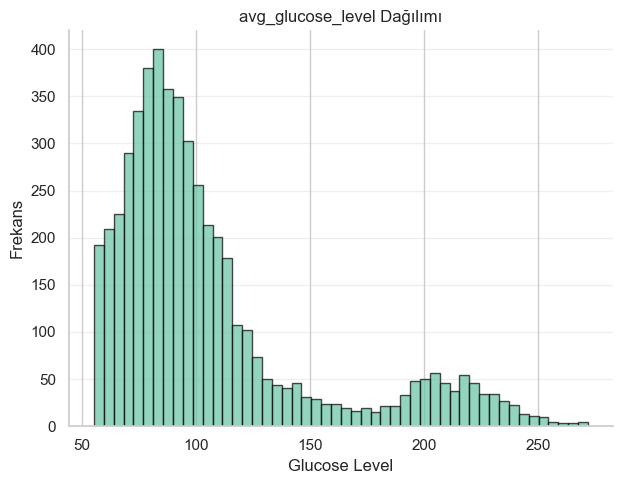

In [ ]:
# avg_glucose_level histogram grafiği
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(dfcleaned['avg_glucose_level'], bins=50, edgecolor='black', color='#66c2a5', alpha=0.7)
plt.xlabel('Glucose Level')
plt.ylabel('Frekans')
plt.title('avg_glucose_level Dağılımı')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# İstatistiksel özet
print(dfcleaned['avg_glucose_level'].describe())
print(f"\nMin: {dfcleaned['avg_glucose_level'].min()}")
print(f"Max: {dfcleaned['avg_glucose_level'].max()}")
print(f"Ortalama: {dfcleaned['avg_glucose_level'].mean():.2f}")
print(f"Medyan: {dfcleaned['avg_glucose_level'].median():.2f}")
print(f"Std Dev: {dfcleaned['avg_glucose_level'].std():.2f}")
print(f"Mode: {dfcleaned['avg_glucose_level'].mode()[0]:.2f}")

count   5,110.00
mean      106.15
std        45.28
min        55.12
25%        77.25
50%        91.88
75%       114.09
max       271.74
Name: avg_glucose_level, dtype: float64

Min: 55.12
Max: 271.74
Ortalama: 106.15
Medyan: 91.88
Std Dev: 45.28
Mode: 93.88


In [ ]:
# Aykırı değer analizi (IQR yöntemi)
Q1 = dfcleaned['avg_glucose_level'].quantile(0.25)
Q3 = dfcleaned['avg_glucose_level'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = dfcleaned[(dfcleaned['avg_glucose_level'] < lower_bound) | 
                      (dfcleaned['avg_glucose_level'] > upper_bound)]

print(f"Q1: {Q1:.2f}")
print(f"Q3: {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Lower Bound: {lower_bound:.2f}")
print(f"Upper Bound: {upper_bound:.2f}")
print(f"\nAykırı değer sayısı: {len(outliers)}")
print(f"Aykırı değer oranı: {len(outliers)/len(dfcleaned)*100:.2f}%")

Q1: 77.25
Q3: 114.09
IQR: 36.84
Lower Bound: 21.98
Upper Bound: 169.36

Aykırı değer sayısı: 627
Aykırı değer oranı: 12.27%


Aykırı değer sayısı çok fazla.
Sağa çarpık bir dağılıma sahip.
Log transformation yapalım:
Bu log dönüşümü dağılımı daha simetrik hale getirir ve modeli daha stabil hale getirir.
Yüksek uç değerlerin etkisini azaltarak modelin glukoza aşırı duyarlı olmasını engeller ve tahmin performansını artırır.

In [ ]:
# Log transformation
dfcleaned['avg_glucose_level_log'] = np.log1p(dfcleaned['avg_glucose_level'])


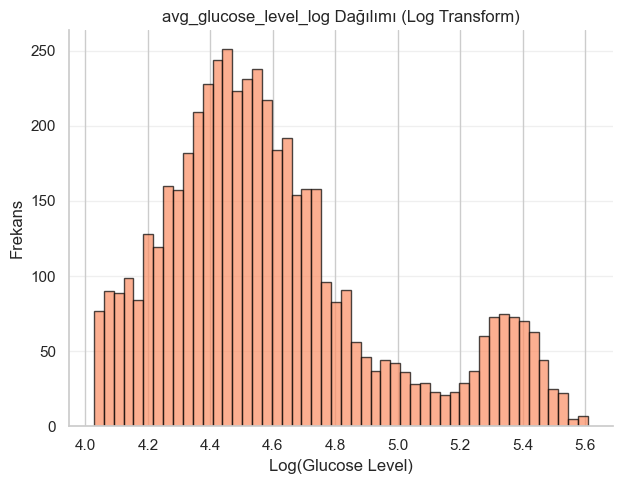

In [ ]:
# Log transformation sonrası histogram grafiği
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(dfcleaned['avg_glucose_level_log'], bins=50, edgecolor='black', color='#fc8d62', alpha=0.7)
plt.xlabel('Log(Glucose Level)')
plt.ylabel('Frekans')
plt.title('avg_glucose_level_log Dağılımı (Log Transform)')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

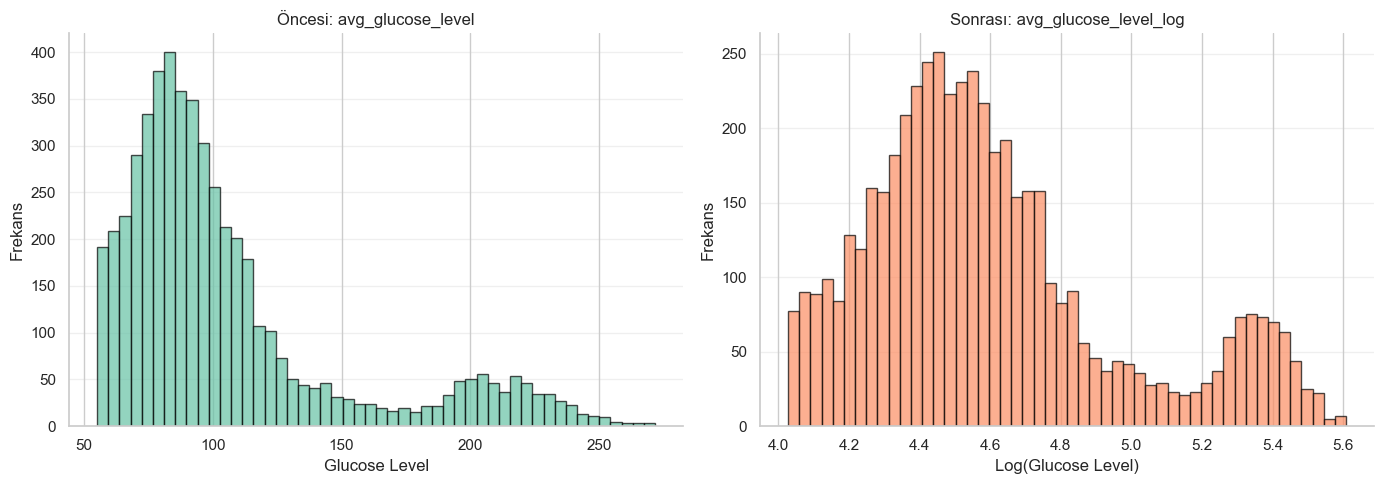

In [ ]:
# Öncesi ve sonrası karşılaştırma
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Orijinal
axes[0].hist(dfcleaned['avg_glucose_level'], bins=50, edgecolor='black', color='#66c2a5', alpha=0.7)
axes[0].set_xlabel('Glucose Level')
axes[0].set_ylabel('Frekans')
axes[0].set_title('Öncesi: avg_glucose_level')
axes[0].grid(axis='y', alpha=0.3)

# Log Transform
axes[1].hist(dfcleaned['avg_glucose_level_log'], bins=50, edgecolor='black', color='#fc8d62', alpha=0.7)
axes[1].set_xlabel('Log(Glucose Level)')
axes[1].set_ylabel('Frekans')
axes[1].set_title('Sonrası: avg_glucose_level_log')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Log dönüşümden sonra:
Dağılım çok daha simetrik
Sağ kuyruk büzüşmüş
Aykırı  etkisi yumuşamış

In [ ]:
# Log transform sonrası aykırı değer analizi
Q1_log = dfcleaned['avg_glucose_level_log'].quantile(0.25)
Q3_log = dfcleaned['avg_glucose_level_log'].quantile(0.75)
IQR_log = Q3_log - Q1_log

lower_bound_log = Q1_log - 1.5 * IQR_log
upper_bound_log = Q3_log + 1.5 * IQR_log

outliers_log = dfcleaned[(dfcleaned['avg_glucose_level_log'] < lower_bound_log) | 
                          (dfcleaned['avg_glucose_level_log'] > upper_bound_log)]

print(f"=== LOG TRANSFORM SONRASI AYKIRI DEĞER ANALİZİ ===")
print(f"Q1: {Q1_log:.2f}")
print(f"Q3: {Q3_log:.2f}")
print(f"IQR: {IQR_log:.2f}")
print(f"Alt Sınır: {lower_bound_log:.2f}")
print(f"Üst Sınır: {upper_bound_log:.2f}")
print(f"\nAykırı değer sayısı: {len(outliers_log)}")
print(f"Aykırı değer oranı: {len(outliers_log)/len(dfcleaned)*100:.2f}%")

=== LOG TRANSFORM SONRASI AYKIRI DEĞER ANALİZİ ===
Q1: 4.36
Q3: 4.75
IQR: 0.39
Alt Sınır: 3.78
Üst Sınır: 5.32

Aykırı değer sayısı: 384
Aykırı değer oranı: 7.51%


Aykırı değer oranı 12.27% değerinden 7.51% ye düşmüş oldu.
Böylece modeli uç değerlere daha az duyarlı hale getirdik.
Ama tamamen uç değerleri kaldırmadık çünkü uç değerler gerçek hastalık değerlerini temsil eder

In [ ]:
dfcleaned

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,avg_glucose_level_log
0,67.00,0,1,228.69,36.60,formerly smoked,1,1,1,0,1,0,0,1,5.44
1,61.00,0,0,202.21,28.10,never smoked,1,0,1,0,0,1,0,0,5.31
2,80.00,0,1,105.92,32.50,never smoked,1,1,1,0,1,0,0,0,4.67
3,49.00,0,0,171.23,34.40,smokes,1,0,1,0,1,0,0,1,5.15
4,79.00,1,0,174.12,24.00,never smoked,1,0,1,0,0,1,0,0,5.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.00,1,0,83.75,28.10,never smoked,0,0,1,0,1,0,0,1,4.44
5106,81.00,0,0,125.20,40.00,never smoked,0,0,1,0,0,1,0,1,4.84
5107,35.00,0,0,82.99,30.60,never smoked,0,0,1,0,0,1,0,0,4.43
5108,51.00,0,0,166.29,25.60,formerly smoked,0,1,1,0,1,0,0,0,5.12


Ağaç tabanlı modeller olan Decision Tree ve Random Forest, veri ölçeklemeye duyarlı olmadıkları ve ham dağılımdan daha fazla bilgi çıkarabildikleri için avg_glucose_level değişkeninin orijinal (raw) halini kullanmak en doğru yaklaşımdır. 

Benzer şekilde XGBoost ve LightGBM de ham veriyi çok iyi işlediğinden raw değer idealdir. 

Buna karşılık Logistic Regression, SVM, KNN ve Neural Network gibi lineer ya da mesafe tabanlı algoritmalar sağa çarpık dağılımlardan ve uç değerlerden doğrudan etkilendiği için bu modellerde log dönüşümü yapılmış ve ölçeklendirilmiş (log + scaled) glukoz değişkeni kullanılmalıdır. Bu sayede hem dağılım normalize edilmiş olur hem de tüm feature’lar aynı ölçekte işlendiği için model kararlılığı ve performansı artar. 

Bu nedenle, projede kullanılacak modellere göre glukoz değişkeninin temsili değişmekte; ağaç tabanlı modellerde raw, lineer ve mesafe tabanlı modellerde ise log + scaled versiyon tercih edilmektedir.

In [ ]:
# Log + Scaled transformation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dfcleaned['avg_glucose_level_log_scaled'] = scaler.fit_transform(
    dfcleaned[['avg_glucose_level_log']]
)

bmi kolonu:
BMI, dağılımı düzgün olsa da Logistic Regression ve SVM gibi ölçek duyarlı modellerin daha doğru ve stabil çalışması için ortak bir ölçeğe getirilmesi gerektiğinden scale edilmiştir.

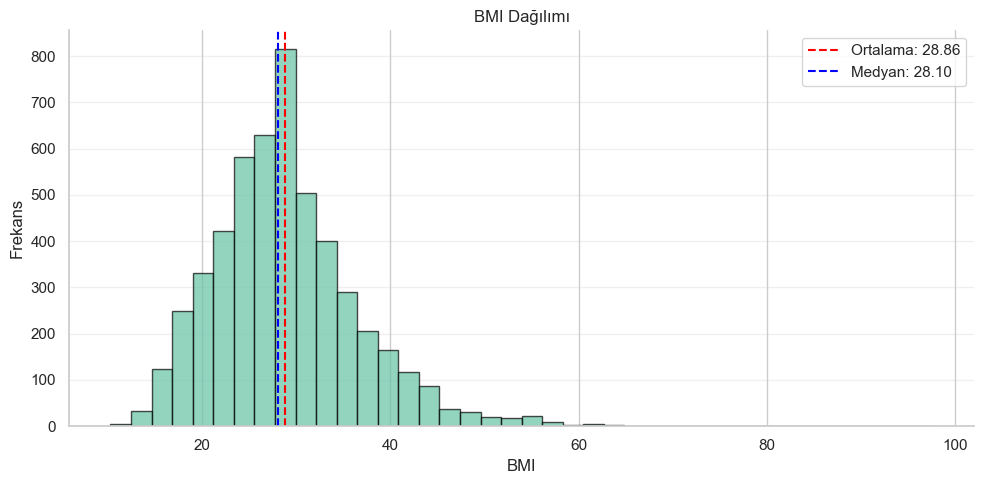

In [ ]:
# BMI histogram grafiği
plt.figure(figsize=(10, 5))
plt.hist(dfcleaned['bmi'], bins=40, edgecolor='black', color='#66c2a5', alpha=0.7)
plt.xlabel('BMI')
plt.ylabel('Frekans')
plt.title('BMI Dağılımı')
plt.axvline(dfcleaned['bmi'].mean(), color='red', linestyle='--', label=f'Ortalama: {dfcleaned["bmi"].mean():.2f}')
plt.axvline(dfcleaned['bmi'].median(), color='blue', linestyle='--', label=f'Medyan: {dfcleaned["bmi"].median():.2f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 3) Aykırı değer analizi
Q1_bmi = dfcleaned['bmi'].quantile(0.25)
Q3_bmi = dfcleaned['bmi'].quantile(0.75)
IQR_bmi = Q3_bmi - Q1_bmi

lower_bound_bmi = Q1_bmi - 1.5 * IQR_bmi
upper_bound_bmi = Q3_bmi + 1.5 * IQR_bmi

outliers_bmi = dfcleaned[(dfcleaned['bmi'] < lower_bound_bmi) | 
                          (dfcleaned['bmi'] > upper_bound_bmi)]

print(f"\n2️⃣ Aykırı Değer Analizi (IQR Yöntemi):")
print(f"Q1: {Q1_bmi:.2f}")
print(f"Q3: {Q3_bmi:.2f}")
print(f"IQR: {IQR_bmi:.2f}")
print(f"Alt Sınır: {lower_bound_bmi:.2f}")
print(f"Üst Sınır: {upper_bound_bmi:.2f}")
print(f"\nAykırı değer sayısı: {len(outliers_bmi)}")
print(f"Aykırı değer oranı: {len(outliers_bmi)/len(dfcleaned)*100:.2f}%")



2️⃣ Aykırı Değer Analizi (IQR Yöntemi):
Q1: 23.80
Q3: 32.80
IQR: 9.00
Alt Sınır: 10.30
Üst Sınır: 46.30

Aykırı değer sayısı: 126
Aykırı değer oranı: 2.47%


In [ ]:
dfcleaned['bmi_scaled'] = scaler.fit_transform(dfcleaned[['bmi']])

BMI Kolonunun Modellerde Kullanımı

Lojistik Regresyon: Ölçek duyarlı bir model olduğu için scaled BMI kullanılmalıdır.

Decision Tree: Ağaç tabanlı yapılar ölçeklemeye ihtiyaç duymaz; bu nedenle orijinal BMI tercih edilir.

Random Forest: Ensemble ağaç modelleri ham veriyi daha iyi işler; orijinal BMI kullanılmalıdır.

SVM (opsiyonel): Mesafe temelli bir algoritma olduğundan scaled BMI zorunludur.

XGBoost (opsiyonel): Boosting yöntemleri ham sayısal değerleri etkili şekilde işlediği için orijinal BMI kullanılmalıdır.

Smoking status kolonu:
Sigara bilgisi bilinmeyen kişilerde inme riski farklı olabilir → model bunu öğrenmeli.
Kategorik bir kolon olduğundan one hot encoding yapılmalı.

In [ ]:
# smoking_status kolonu analizi
print(dfcleaned['smoking_status'].unique())
print(f"\nSmoking Status dağılımı:")
print(dfcleaned['smoking_status'].value_counts())

['formerly smoked' 'never smoked' 'smokes' 'Unknown']

Smoking Status dağılımı:
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64


In [ ]:
dfcleaned = pd.get_dummies(dfcleaned, columns=['smoking_status'], drop_first=True, dtype=int)

In [ ]:
dfcleaned.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,avg_glucose_level_log,avg_glucose_level_log_scaled,bmi_scaled,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.00,0,1,228.69,36.60,1,1,1,0,1,0,0,1,5.44,2.32,1.01,1,0,0
1,61.00,0,0,202.21,28.10,1,0,1,0,0,1,0,0,5.31,1.98,-0.10,0,1,0
2,80.00,0,1,105.92,32.50,1,1,1,0,1,0,0,0,4.67,0.19,0.47,0,1,0
3,49.00,0,0,171.23,34.40,1,0,1,0,1,0,0,1,5.15,1.52,0.72,0,0,1
4,79.00,1,0,174.12,24.00,1,0,1,0,0,1,0,0,5.17,1.57,-0.63,0,1,0


In [ ]:
dfcleaned.dtypes

age                               float64
hypertension                        int64
heart_disease                       int64
avg_glucose_level                 float64
bmi                               float64
stroke                              int64
gender_Male                         int64
ever_married_Yes                    int64
work_type_Never_worked              int64
work_type_Private                   int64
work_type_Self-employed             int64
work_type_children                  int64
Residence_type_Urban                int64
avg_glucose_level_log             float64
avg_glucose_level_log_scaled      float64
bmi_scaled                        float64
smoking_status_formerly smoked      int64
smoking_status_never smoked         int64
smoking_status_smokes               int64
dtype: object

Böylece "dfcleaned" Modellenmeye hazır bir dataframe haline getirilmiştir.

# ADIM 1: Veri Hazırlığı ve Train/Test Split

In [ ]:

# dfcleaned yoksa üstteki satırların çalıştırılması gerekebilir.

# 1. Feature Seçimi
# Logistic Regression için uygun feature'ları seçiyoruz.
# Not: Tree modelleri için raw veriler daha iyi olabilir ama LR için scaled versiyonlar şart.
scaler = StandardScaler()
dfcleaned['age_scaled'] = scaler.fit_transform(dfcleaned[['age']])
#age_scaled olmadıgından ekledik
lr_features = [
    'age_scaled',
    'hypertension',
    'heart_disease',
    'avg_glucose_level_log_scaled', 
    'bmi_scaled',
    'gender_Male',
    'ever_married_Yes',
    'work_type_Never_worked', 
    'work_type_Private', 
    'work_type_Self-employed', 
    'work_type_children',
    'Residence_type_Urban',
    'smoking_status_formerly smoked',
    'smoking_status_never smoked',
    'smoking_status_smokes'
]



print("Kullanılacak Feature'lar:", lr_features)

# 2. X ve y Ayrımı
X = dfcleaned[lr_features]
y = dfcleaned['stroke']

# 3. Train / Test Ayrımı
# Stratify=y diyerek inme oranını (dengesizliği) her iki sette de koruyoruz.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("-" * 30)
print(f"Train Set Boyutu: {X_train.shape}")
print(f"Test Set Boyutu : {X_test.shape}")
print("-" * 30)
print(f"Train içindeki İnme (1) Oranı: {y_train.mean():.4f}")
print(f"Test içindeki İnme (1) Oranı : {y_test.mean():.4f}")


Kullanılacak Feature'lar: ['age_scaled', 'hypertension', 'heart_disease', 'avg_glucose_level_log_scaled', 'bmi_scaled', 'gender_Male', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']
------------------------------
Train Set Boyutu: (4088, 15)
Test Set Boyutu : (1022, 15)
------------------------------
Train içindeki İnme (1) Oranı: 0.0487
Test içindeki İnme (1) Oranı : 0.0489


In [1]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [14]:
# SMOTE + StandarScaler + Logistic Regression Pipeline
logreg_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scale', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

print("Model Eğitiliyor...")
logreg_pipeline.fit(X_train, y_train)
print("Eğitim Tamamlandı.")

NameError: name 'StandardScaler' is not defined